In [1]:
import importlib
from IPython.display import clear_output
from IPython.core.debugger import set_trace

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import keras
import keras.layers as layers
from keras import backend as K
import tensorflow as tf

import models

C:\Users\Jon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
y_power = 6
n_y = 2**y_power

## Test a Distribution

<IPython.core.display.Javascript object>


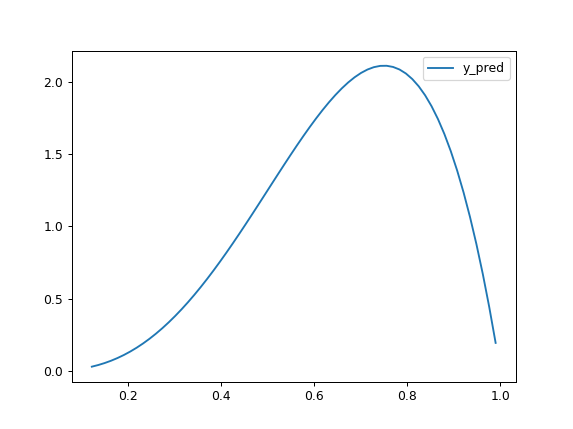

In [4]:
distribution = stats.beta
args = (4,2)
lim = (10**-3,10**-3)

y_x = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
y = distribution.pdf(y_x, *args)
      
plt.figure()
plt.plot(y_x, y, label='y_pred')
plt.legend()

## Dataset

### Select Distributions

In [8]:
set_distributions = [stats.norm, stats.t, stats.powernorm, stats.beta]
arg_placeholders = [list(), (None,), (None,), (None, None)]

In [9]:
distributions = list()
abs_power_lim = -6
lims = list()
distrib_args = list()
n_type = 2**12
for i in range(n_type):
    for distribution, args_placeholder in zip(set_distributions,arg_placeholders):        
        successful = False
        while not successful:
            abs1 = 10 ** (np.random.random() * abs_power_lim)
            abs2 = 10 ** (np.random.random() * abs_power_lim)
            args = tuple(np.random.randint(1,10) for _ in args_placeholder)
            x_1 = distribution.ppf(abs1, *args)
            x_2 = distribution.ppf(1-abs2, *args)
            if x_1 > -5 and x_2 < 5:
                lims.append((abs1,abs2))
                distrib_args.append(args)
                distributions.append(distribution)
                successful = True

### Generate Curves

In [10]:
y_x = np.nan * np.ones((len(distributions),n_y))
y_pdf = np.nan * np.ones((len(distributions),n_y))
for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
    y_x[i,:] = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
    y = distribution.pdf(y_x[i,:], *args)
    y.reshape((1, y.size))    
    y_pdf[i,:] = y
    
n_x = list(set([ j * 2**i for i in range(1,y_power) for j in (2,3,5)]))
n_x = np.array(n_x)
n_x.sort()
x_x_list = list()
x_pdf_list = list()
y_list = list()
for n in n_x:  
    x_pdf = np.nan * np.ones((len(distributions),n_y))
    for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
        x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
        x_pdf_pre = distribution.pdf(x_x,*args)
        x_pdf[i,:] = np.interp(y_x[i,:], x_x, x_pdf_pre)
    x_pdf_list.append(x_pdf)

n_x: 4


<IPython.core.display.Javascript object>


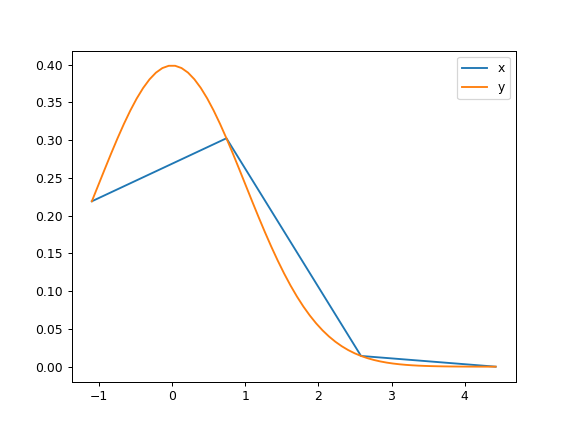

In [11]:
sample_index = 0
distribution_index = 0
print('n_x: {0}'.format(n_x[sample_index]))
plt.figure()
plt.plot(y_x[distribution_index], 
         x_pdf_list[sample_index][distribution_index,:], label='x')
plt.plot(y_x[distribution_index,:], y_pdf[distribution_index,:], label='y')
plt.legend()

In [12]:
print('Individual Curves: {0}'.format(len(distributions)))
print('Total Curves:      {0}'.format(len(distributions)*len(n_x)))

Individual Curves: 16384
Total Curves:      245760


## Keras Model

In [4]:
keras.backend.clear_session()

n_a = 100
n_dense = 100
drop_rate = 0.25

In [23]:
importlib.reload(models)

<module 'models' from 'F:\\Dev\\Python\\LSTM_interpolator\\models.py'>

In [5]:
model = models.feedforward(n_a, n_dense, drop_rate, n_y)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 200), (None, 81600       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1, 200)       160800      input_2[0][0]                    
                                                                 bidirectional_1[0][1]            
          

In [6]:
model_file = 'LSTM_2L_skipper_interp.h5'
save_freq = 10
model.load_weights(model_file)

In [13]:
def append_history(history, loss, val_loss):
    if loss[n_x[i]] is not None:
        loss.update({n_x[i]: loss[n_x[i]].append(history.history['loss'])})
        val_loss.update({n_x[i]: val_loss[n_x[i]].append(history.history['val_loss'])})
    else: # initialize list
        loss.update({n_x[i]: list()})
        loss.update({n_x[i]: loss[n_x[i]].append(history.history['loss'])})
        val_loss.update({n_x[i]: list()})
        val_loss.update({n_x[i]: val_loss[n_x[i]].append(history.history['val_loss'])})

In [14]:
decoder_in = np.zeros((x_pdf_list[0].shape[0],1,n_a))
rounds = 100
loss = dict.fromkeys(n_x,None)
val_loss = dict.fromkeys(n_x,None)
for j in range(0,rounds):
    if not j%save_freq:
        model.save_weights(model_file)
    if j == 0:
        lr = 0.01
        optim = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    if j == 5:
        lr = 0.001
        optim = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    elif j == 30:
        lr = 0.0005
        optim = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    elif j == 55:
        lr = 0.0001
        optim = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    elif j == 75:
        lr = 0.00001
        optim = keras.optimizers.Adam(lr=lr)
        model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
    
    for i in range(len(x_pdf_list)):
        ranint = np.random.randint(0, len(x_pdf_list))
        x_pdf = x_pdf_list[ranint]
        clear_output()
        print('Round {0} out of {1}     (LR: {2})'.format(j+1, rounds, lr))
        print('Set of Curves: {0} out of {1}  ==>  n_x: {2}'.format(i+1, len(x_pdf_list), n_x[i]))
        x_pdf = x_pdf.reshape((x_pdf.shape[0],x_pdf.shape[1],1))
        history = model.fit(x=[x_pdf, decoder_in], y=y_pdf, epochs=2, batch_size=512, validation_split=0.25)
        append_history(history, loss, val_loss)
print('\n Completed!!')

Round 100 out of 100     (LR: 1e-05)
Set of Curves: 15 out of 15  ==>  n_x: 160
Train on 12288 samples, validate on 4096 samples
Epoch 1/2
12288/12288 [==============================] - 8s 635us/step - loss: 0.0031 - acc: 0.2803 - val_loss: 0.0015 - val_acc: 0.2817
Epoch 2/2
12288/12288 [==============================] - 8s 635us/step - loss: 0.0031 - acc: 0.2816 - val_loss: 0.0015 - val_acc: 0.2822

 Completed!!


<IPython.core.display.Javascript object>


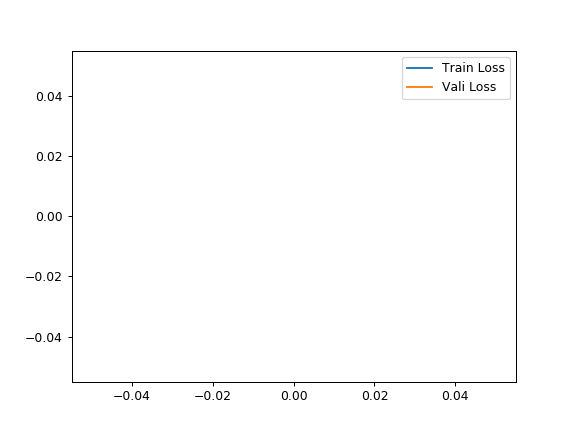

In [16]:
n_x = 16
plt.figure()
plt.plot(np.array(loss[n_x]).flatten(), label='Train Loss')
plt.plot(np.array(val_loss[n_x]).flatten(), label='Vali Loss')
plt.legend()

In [ ]:
model.save_weights(model_file)

## Test Model

n_x: 6


<IPython.core.display.Javascript object>


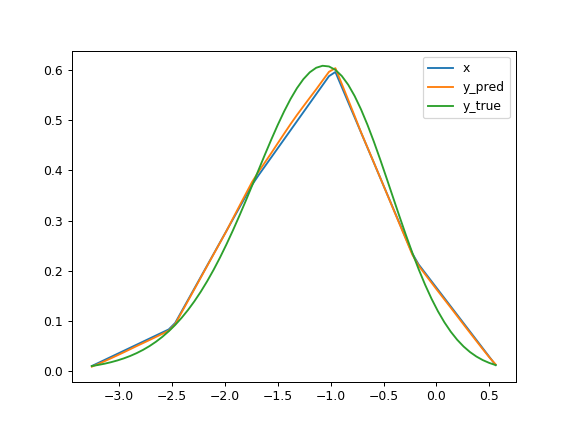

In [22]:
i = 1254
distribution = distributions[i]
args = distrib_args[i]
lim = lims[i]
n = n_x[1]

y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
x_pdf = np.interp(y_x, x_x, x_pdf)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)

y_pdf_pred = model.predict(x=[x_pdf, decoder_in])


print('n_x: '+str(n))
plt.figure()
plt.plot(y_x, x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.plot(y_x, y_pdf[i], label='y_true')
plt.legend()